<a href="https://colab.research.google.com/github/BVika/Methods_of_semantic_information_processing/blob/main/%D0%9B%D0%B0%D0%B1_5ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Сбор данных (Collect data) и Загрузка данных:

Датасет 20 Newsgroups (20 Новостных Групп) из библиотеки sklearn. Этот датасет содержит коллекцию сообщений, опубликованных в разных группах новостей в 1990-е годы. Он включает текстовые данные, которые относятся к 20 различным категориям. Эти категории представляют собой разные темы, например, «спорт», «наука», «компьютеры», «прикладная математика», «политика» и т. д.

In [55]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

# Загружаем данные
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Просматриваем первые 5 записей
data = pd.DataFrame({'text': newsgroups.data, 'category': newsgroups.target})
print(data.head())


                                                text  category
0  \n\nI am sure some bashers of Pens fans are pr...        10
1  My brother is in the market for a high-perform...         3
2  \n\n\n\n\tFinally you said what you dream abou...        17
3  \nThink!\n\nIt's the SCSI card doing the DMA t...         3
4  1)    I have an old Jasmine drive which I cann...         4


## Предобработка данных

In [56]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

def preprocess(text):
    # Приводим к нижнему регистру
    text = text.lower()
    # Убираем все неалфавитные символы
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Токенизация
    words = word_tokenize(text)
    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in words if word not in ENGLISH_STOP_WORDS])
    return text

# Применяем предобработку ко всем текстам
data['cleaned_text'] = data['text'].apply(preprocess)
print(data['cleaned_text'].head())


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    sure bashers pen fan pretty confused lack kind...
1    brother market highperformance video card supp...
2    finally said dream mediterranean new area grea...
3    think scsi card doing dma transfer disk scsi c...
4    old jasmine drive use new understanding upsate...
Name: cleaned_text, dtype: object


## Анализ данных

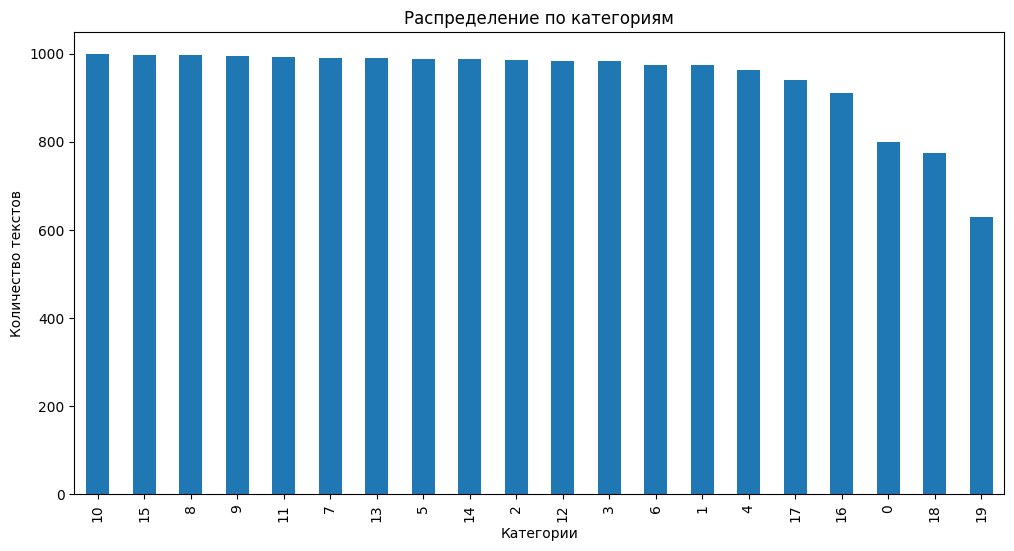

In [57]:
import matplotlib.pyplot as plt

category_counts = data['category'].value_counts()
category_counts.plot(kind='bar', figsize=(12, 6))
plt.title("Распределение по категориям")
plt.xlabel("Категории")
plt.ylabel("Количество текстов")
plt.show()


## Векторизация текста

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3)) # Ограничим количество признаков
X = vectorizer.fit_transform(data['cleaned_text'])
print(X.shape)


(18846, 5000)


## Кластеризация

Выбираем количество кластеров, которое дает лучший Silhouette Score

In [59]:
from sklearn.metrics import silhouette_score

best_score = -1
best_k = 2
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    if score > best_score:
        best_score = score
        best_k = k

print(f"Лучшее количество кластеров для KMeans: {best_k} с Silhouette Score: {best_score}")

Лучшее количество кластеров для KMeans: 4 с Silhouette Score: 0.010921263041059528


In [60]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Пробуем KMeans с 4 кластерами и более эффективной инициализацией
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X)

# Добавляем кластерные метки в данные
data['predicted_category'] = kmeans.labels_

# Проверим Silhouette Score для нового KMeans
score = silhouette_score(X, kmeans.labels_)
print(f"Silhouette Score для KMeans с 4 кластерами: {score:.4f}")


Silhouette Score для KMeans с 4 кластерами: 0.0083


Silhouette Score для KMeans с 4 кластерами: 0.0083


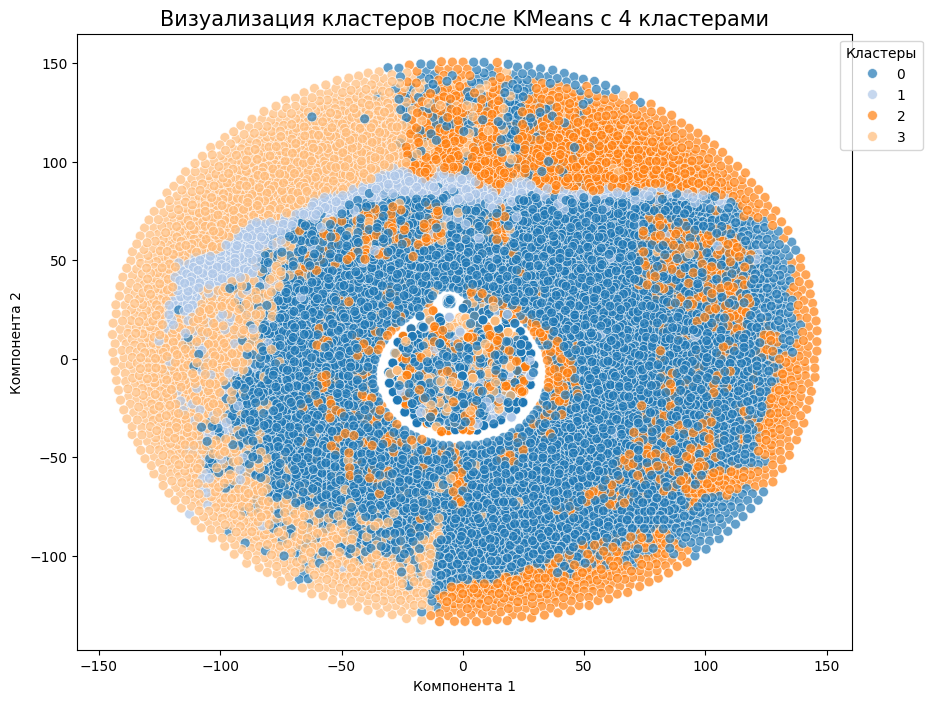

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Применяем KMeans с 4 кластерами
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X)

# Добавляем кластерные метки в данные
data['predicted_category'] = kmeans.labels_

# Оценим качество кластеризации с помощью Silhouette Score
score = silhouette_score(X, kmeans.labels_)
print(f"Silhouette Score для KMeans с 4 кластерами: {score:.4f}")

# Преобразуем данные с помощью t-SNE для визуализации в 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X.toarray())  # Преобразуем разреженную матрицу в обычный массив

# Визуализируем кластеризацию
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=data['predicted_category'], palette='tab20', s=50, alpha=0.7)

plt.title("Визуализация кластеров после KMeans с 4 кластерами", fontsize=15)
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.legend(title="Кластеры", loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()


## Сравнение с реальной разметкой

In [61]:
from sklearn.metrics import adjusted_rand_score

# Оценка качества кластеризации с помощью Adjusted Rand Index
ari = adjusted_rand_score(data['category'], data['predicted_category'])
print(f"Adjusted Rand Index: {ari:.4f}")


Adjusted Rand Index: 0.0467


## Разделение на выборки

In [62]:
from sklearn.model_selection import train_test_split

# Разделим данные на train и test
X_train, X_test, y_train, y_test = train_test_split(X, data['category'], test_size=0.2, random_state=42)

# Разделим train на train и val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"Размеры выборок: Train - {X_train.shape}, Validation - {X_val.shape}, Test - {X_test.shape}")


Размеры выборок: Train - (13568, 5000), Validation - (1508, 5000), Test - (3770, 5000)
